In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from rl_env.trading_env import BondFuturesTradingEnv

from stable_baselines.sac.policies import LnMlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import SAC

We are assuming that the trade cost is 2% of the whole amount traded.  
The agents starts with a capital of 3 and is allowed to take actions from 1 to -1 for each future contract. The actions represent exposures. The reward is simply defined as the return at each step.

In [3]:
n_timesteps = 100000

env = DummyVecEnv([lambda: BondFuturesTradingEnv(validation=False)])
policy_kwargs = dict(layers=[32, 32])

model = SAC(LnMlpPolicy, env, verbose=0, gamma=0.99, tensorboard_log='logs/', full_tensorboard_log=False,
            train_freq=1, batch_size=64, tau=0.005, policy_kwargs=policy_kwargs, buffer_size=50000,
            learning_starts=5000)

model.learn(total_timesteps=n_timesteps)
model.save('models/SAC.pkl')

W1013 23:16:10.650338 13052 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\tf_util.py:98: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1013 23:16:10.651339 13052 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\tf_util.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1013 23:16:10.658312 13052 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\sac\sac.py:150: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1013 23:16:10.659311 13052 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\input.py:25: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W

#### Results on the training enviroment
This does seem a bit ridiculous, but I can't really figure out what is going on

W1013 23:51:26.526308 22092 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\tf_util.py:98: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1013 23:51:26.527294 22092 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\tf_util.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1013 23:51:26.532274 22092 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\sac\sac.py:150: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1013 23:51:26.533297 22092 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\input.py:25: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W

------------------------------
Total % Return:        2881.362%
Total % Annual Return: 1592.332%
Maximum % Drawdown:    -96.651%
Sharpe Ratio:          3.553
------------------------------


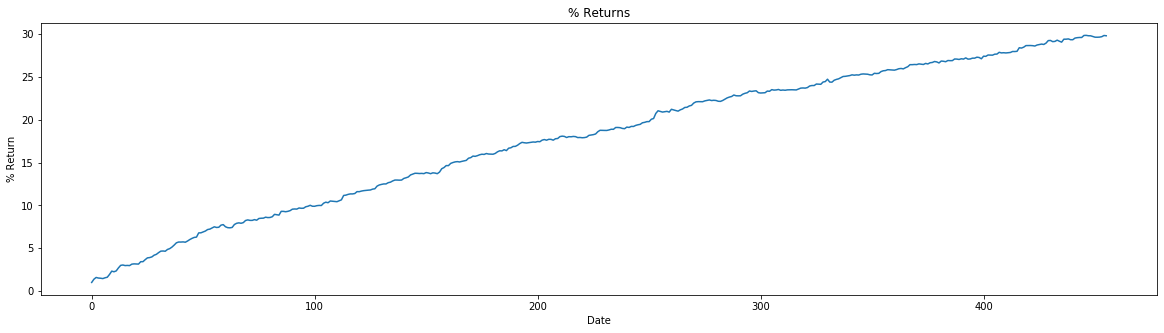

In [3]:
val_env_train = BondFuturesTradingEnv(validation=False)
obs = val_env_train.reset()
done = False
model = SAC.load('models/SAC.pkl')
    
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = val_env_train.step(action)
    
val_env_train.render()

#### Results on the validation data
This doesn't take into account that the capital accumilates over time

------------------------------
Total % Return:        197.645%
Total % Annual Return: 436.9%
Maximum % Drawdown:    -77.838%
Sharpe Ratio:          3.554
------------------------------


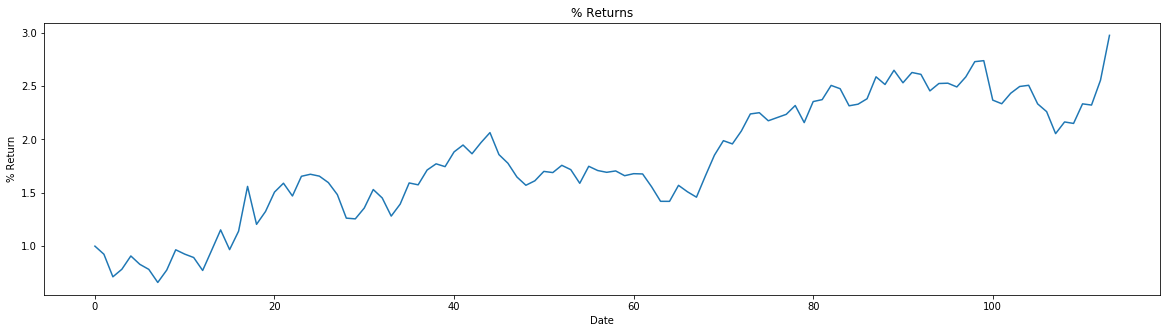

In [4]:
val_env_test = BondFuturesTradingEnv(validation=True)
obs = val_env_test.reset()
done = False
model = SAC.load('models/SAC.pkl')
    
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = val_env_test.step(action)
    
val_env_test.render()

In [5]:
cumulative_return_train = np.array(val_env_train.portfolio_returns).cumsum()
cumulative_return_test = np.array(val_env_test.portfolio_returns).cumsum()

dates = np.load('rl_env/data/dates.npy', allow_pickle=True)

In [7]:
train_data = pd.DataFrame(cumulative_return_train, index=dates[:456], columns=['Cumulative Return'])
test_data = pd.DataFrame(cumulative_return_test, index=dates[456:], columns=['Cumulative Return'])

In [8]:
train_data.to_csv('results/Train_Results.csv')
test_data.to_csv('results/Test_Results.csv')